# Import relevant libraries

In [1]:
#import libries
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

from sklearn import metrics 

In [110]:
#load dataset
df = pd.read_csv('./datasets/cleaned_v2.csv', low_memory = False)

In [111]:
# pd.set_option('display.max_columns', None)
df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,political_parties,blk_num,blk_alpha,transaction_year,transaction_month,lease_year,end_lease_year
0,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,9000.0,RULING,309,-,1990,1,1977,2076
1,ANG MO KIO,1 ROOM,04 TO 06,31.0,IMPROVED,6000.0,RULING,309,-,1990,1,1977,2076
2,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,8000.0,RULING,309,-,1990,1,1977,2076
3,ANG MO KIO,1 ROOM,07 TO 09,31.0,IMPROVED,6000.0,RULING,309,-,1990,1,1977,2076
4,ANG MO KIO,3 ROOM,04 TO 06,73.0,NEW GENERATION,47200.0,RULING,216,-,1990,1,1976,2075


## Preprocessing of Data

## Split data into features and target

In [4]:
X = df.drop(columns = 'resale_price')
y = df['resale_price']

In [5]:
X.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,political_parties,blk_num,blk_alpha,transaction_year,transaction_month,lease_year,end_lease_year
0,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,RULING,309,-,1990,1,1977,2076
1,ANG MO KIO,1 ROOM,04 TO 06,31.0,IMPROVED,RULING,309,-,1990,1,1977,2076
2,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,RULING,309,-,1990,1,1977,2076
3,ANG MO KIO,1 ROOM,07 TO 09,31.0,IMPROVED,RULING,309,-,1990,1,1977,2076
4,ANG MO KIO,3 ROOM,04 TO 06,73.0,NEW GENERATION,RULING,216,-,1990,1,1976,2075


In [6]:
y.head()

0     9000.0
1     6000.0
2     8000.0
3     6000.0
4    47200.0
Name: resale_price, dtype: float64

Remarks: X and y has been split

## Initiate train_test_split()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Show split of train and test data

In [8]:
print(len(X_train), len(X_test))

674251 224751


In [9]:
print(len(y_train),len(y_test) )

674251 224751


In [10]:
# reset index
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

Remarks: Train test split was sucessful 

## Split X_train & X_test into categorical and numerical.

### X_train

In [11]:
columns = X_train.columns
columns

Index(['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'political_parties', 'blk_num', 'blk_alpha', 'transaction_year',
       'transaction_month', 'lease_year', 'end_lease_year'],
      dtype='object')

In [12]:
cat_X_train = pd.DataFrame()
num_X_train = pd.DataFrame()
for i in columns:
    if 'object' == str(X_train[i].dtypes):
        cat_X_train = pd.concat([cat_X_train, X_train[i]], axis = 1)
    else:
        num_X_train = pd.concat([num_X_train, X_train[i]], axis = 1)

In [13]:
cat_X_train.head()

,town,flat_type,storey_range,flat_model,political_parties,blk_alpha
0,CLEMENTI,3 ROOM,07 TO 09,NEW GENERATION,RULING,-
1,JURONG WEST,4 ROOM,04 TO 06,IMPROVED,RULING,-
2,HOUGANG,4 ROOM,01 TO 03,MODEL A,OPPOSITION,-
3,ANG MO KIO,3 ROOM,07 TO 09,NEW GENERATION,RULING,-
4,TOA PAYOH,4 ROOM,16 TO 18,IMPROVED,RULING,-


In [14]:
num_X_train.head()

,floor_area_sqm,blk_num,transaction_year,transaction_month,lease_year,end_lease_year
0,67.0,306,2008,10,1979,2078
1,87.0,219,1997,11,1975,2074
2,103.0,130,2010,8,1984,2083
3,68.0,332,1994,2,1981,2080
4,82.0,227,2012,1,1976,2075


As the dates are in continuous format, it would be best to not perform one hot encoding.
Strategy: 
1. add date columns to X_train
2. drop date columns from cat_X_train

### X_test

In [15]:
columns_test = X_test.columns
columns_test

Index(['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'political_parties', 'blk_num', 'blk_alpha', 'transaction_year',
       'transaction_month', 'lease_year', 'end_lease_year'],
      dtype='object')

In [16]:
cat_X_test = pd.DataFrame()
num_X_test = pd.DataFrame()
for i in columns:
    if 'object' == str(X_test[i].dtypes):
        cat_X_test = pd.concat([cat_X_test, X_test[i]], axis = 1)
    else:
        num_X_test = pd.concat([num_X_test, X_test[i]], axis = 1)

In [17]:
cat_X_test.head()

,town,flat_type,storey_range,flat_model,political_parties,blk_alpha
0,BUKIT BATOK,3 ROOM,07 TO 09,NEW GENERATION,RULING,-
1,JURONG EAST,3 ROOM,13 TO 15,IMPROVED,RULING,-
2,HOUGANG,4 ROOM,07 TO 09,SIMPLIFIED,OPPOSITION,-
3,SENGKANG,3 ROOM,13 TO 15,MODEL A,RULING,C
4,KALLANG/WHAMPOA,4 ROOM,16 TO 18,MODEL A,RULING,-


In [18]:
num_X_test.head()

,floor_area_sqm,blk_num,transaction_year,transaction_month,lease_year,end_lease_year
0,68.0,364,1998,6,1987,2086
1,77.0,33,2016,2,1977,2076
2,84.0,636,2006,10,1987,2086
3,67.0,443,2017,9,2012,2111
4,90.0,13,2009,11,2004,2103


As the dates are in continuous format, it would be best to not perform one hot encoding.
Strategy: 
1. add date columns to X_train
2. drop date columns from cat_X_train

In [19]:
print(cat_X_test.shape)
print(num_X_test.shape)

(224751, 6)
(224751, 6)


Remarks: columns have been split into categorical and numerical dataframes

## OneHotEncoder for cat_X_train & cat_X_test

In [20]:
print(cat_X_train.shape , cat_X_test.shape)

(674251, 6) (224751, 6)


In [21]:
encoder = OneHotEncoder()

In [22]:
X_train_encoded = encoder.fit_transform(cat_X_train)
X_test_encoded = encoder.transform(cat_X_test)

Remarks: OneHotEncoder have been created.

## Combine num_X and cat_X into X

In [23]:
X_train_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_train_encoded)
X_test_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_test_encoded)

In [24]:
print(X_train_encoded_df.shape, X_test_encoded_df.shape)

(674251, 93) (224751, 93)


In [25]:
X_train = pd.concat([num_X_train, X_train_encoded_df], axis = 1)
X_test = pd.concat([num_X_test, X_test_encoded_df], axis = 1)

In [26]:
print(X_train.shape)
print(X_test.shape)

(674251, 99)
(224751, 99)


Remarks: Columns has been concat.

## Scaling of Train & Test data

In [27]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [28]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Models

### Ridge CV

In [29]:
rcv = RidgeCV()

In [30]:
pipe_rcv_gs = Pipeline([('sc',sc),('rcv',rcv)])

In [31]:
pipe_rcv_gs_params = {'rcv__alphas':[0.1, 1.0, 10.0]}

In [32]:
rcv_gs = GridSearchCV(pipe_rcv_gs, pipe_rcv_gs_params, cv=5, verbose=1, error_score='raise')

In [33]:
rcv_model = rcv_gs.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge

In [34]:
rcv_gs.best_params_

{'rcv__alphas': 10.0}

In [35]:
rcv_gs.score(X_test,y_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8365284394520178

In [36]:
rcv_gs.score(X_train,y_train)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8364049368595561

In [37]:
rcv_pred = rcv_model.predict(X_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [38]:
np.sqrt(metrics.mean_squared_error(y_test, rcv_pred))

66048.3393576043

In [39]:
rcv_y_test = y_test.reset_index(drop=True)

In [40]:
rcv_pred_df = pd.DataFrame(rcv_y_test)

In [41]:
rcv_pred_df.head()

,resale_price
0,139000.0
1,303000.0
2,186000.0
3,330000.0
4,500000.0


In [42]:
rcv_df = pd.concat([rcv_pred_df, pd.DataFrame({'model_predictions': rcv_pred})], axis = 1)

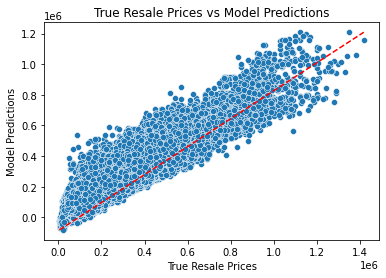

In [43]:
sns.scatterplot(x=rcv_df['resale_price'], y=rcv_df['model_predictions'])
plt.plot([min(rcv_df['resale_price']), max(rcv_df['resale_price'])], [min(rcv_df['model_predictions']), max(rcv_df['model_predictions'])], color='red', linestyle='--')
plt.title('True Resale Prices vs Model Predictions')
plt.xlabel('True Resale Prices')
plt.ylabel('Model Predictions')
plt.show()

The observation of a systematic bias in the predicted values against the true values indicates that the model, similar to the base model, consistently deviates from the ideal linear relationship. This bias suggests that the model has a tendency to either overestimate or underestimate the true values consistently. This could be a result of various factors such as the model's underlying assumptions or limitations in capturing the complexity of the data.

Furthermore, the scatter of data points around the diagonal line indicates the presence of prediction error. The scattered distribution of points suggests that there is a degree of variability or uncertainty in the model's predictions. The prediction error could stem from various sources, including the model's inability to capture all relevant features or the presence of unaccounted-for noise in the data.

#### Observations

Hyperparameter tuning was conducted on the RidgeCV model, resulting in a train score and test score both standing at 83.6%. This parity suggests that the model is not suffering from overfitting or underfitting issues. However, upon evaluating the root mean squared error (RMSE) score of the tuned RidgeCV model, it was found to be slightly higher than that of the base model, measuring at 66,048. Consequently, it can be concluded that although the model's fitting appears to be satisfactory, there is still room for improvement in terms of predictive accuracy. The $R^2$ scores and RMSE scores can be further enhanced through additional experimentation and refinement of the model's hyperparameters, potentially leading to a more accurate and precise model for the given task.

### Lasso CV

In [44]:
lcv = LassoCV()

In [45]:
pipe_lcv_gs = Pipeline([('sc',sc),('lcv',lcv)])

In [46]:
pipe_lcv_gs_params = {'lcv__n_alphas':[1, 10, 50, 100],
                     'lcv__random_state':[42]}

In [47]:
lcv_gs = GridSearchCV(pipe_lcv_gs, pipe_lcv_gs_params, cv=5, verbose=1, error_score='raise')

In [49]:
lcv_model = lcv_gs.fit(X_train, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge

In [50]:
lcv_gs.best_params_

{'lcv__n_alphas': 1, 'lcv__random_state': 42}

In [51]:
lcv_gs.score(X_test,y_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8364696835188766

In [52]:
lcv_gs.score(X_train,y_train)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.836330636610751

In [53]:
lcv_pred = lcv_model.predict(X_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [54]:
np.sqrt(metrics.mean_squared_error(y_test, lcv_pred))

66060.20803724503

In [55]:
lcv_y_test = y_test.reset_index(drop=True)

In [56]:
lcv_pred_df = pd.DataFrame(lcv_y_test)

In [57]:
lcv_pred_df.head()

,resale_price
0,139000.0
1,303000.0
2,186000.0
3,330000.0
4,500000.0


In [58]:
lcv_df = pd.concat([lcv_pred_df, pd.DataFrame({'model_predictions': lcv_pred})], axis = 1)

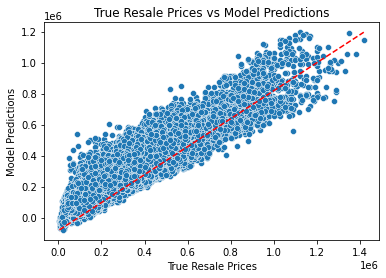

In [59]:
sns.scatterplot(x=lcv_df['resale_price'], y=lcv_df['model_predictions'])
plt.plot([min(lcv_df['resale_price']), max(lcv_df['resale_price'])], [min(lcv_df['model_predictions']), max(lcv_df['model_predictions'])], color='red', linestyle='--')
plt.title('True Resale Prices vs Model Predictions')
plt.xlabel('True Resale Prices')
plt.ylabel('Model Predictions')
plt.show()

Similar to the base model, there are still observation of systematic bias and uncertainty of model predictions.

#### Observations

In the context of hyperparameter tuning on LassoCV, it was observed that both the train and test scores yielded the same value of 83.6%. This equality suggests that the model is neither suffering from overfitting nor underfitting, indicating a balanced performance. However, when examining the root mean squared error (RMSE) score, it was found to be similar to the RMSE score obtained from RidgeCV, without notable improvement. While the model's performance can be deemed satisfactory, it suggests that alternative models could be explored to achieve better results in terms of the R^2 score and a lower RMSE score. By considering other models or fine-tuning the existing one, it may be possible to enhance the predictive accuracy and precision, potentially leading to improved performance in the given task.

### Elastic Net

In [60]:
enet_alphas = np.linspace(0.5, 1.0, 100)
enet = ElasticNetCV(alphas = enet_alphas, cv = 5)

In [61]:
pipe_enet_gs = Pipeline([('sc',sc),('enet',enet)])

In [62]:
pipe_enet_gs_params = {'enet__l1_ratio':[0.1,0.5,0.1]}

In [63]:
enet_gs = GridSearchCV(pipe_enet_gs, pipe_enet_gs_params, cv=5, verbose=1, error_score='raise')

In [64]:
enet_model = enet_gs.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge

In [65]:
enet_gs.best_params_

{'enet__l1_ratio': 0.5}

In [66]:
enet_gs.score(X_test,y_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8149288413656685

In [67]:
enet_gs.score(X_train,y_train)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8143671750052088

In [68]:
enet_pred = enet_model.predict(X_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [69]:
np.sqrt(metrics.mean_squared_error(y_test, enet_pred))

70276.50748874515

In [70]:
enet_y_test = y_test.reset_index(drop=True)

In [71]:
enet_pred_df = pd.DataFrame(enet_y_test)

In [72]:
enet_pred_df.head()

,resale_price
0,139000.0
1,303000.0
2,186000.0
3,330000.0
4,500000.0


In [73]:
enet_df = pd.concat([enet_pred_df, pd.DataFrame({'model_predictions': enet_pred})], axis = 1)

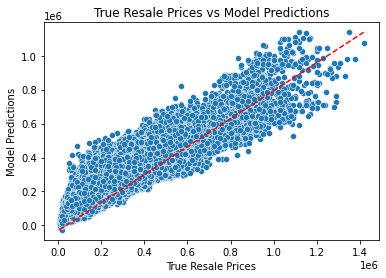

In [74]:
sns.scatterplot(x=enet_df['resale_price'], y=enet_df['model_predictions'])
plt.plot([min(enet_df['resale_price']), max(enet_df['resale_price'])], [min(enet_df['model_predictions']), max(enet_df['model_predictions'])], color='red', linestyle='--')
plt.title('True Resale Prices vs Model Predictions')
plt.xlabel('True Resale Prices')
plt.ylabel('Model Predictions')
plt.show()

It is observed that there is still some form of systematic bias in the predicted values against true values. In addition, there is indication of large scatter in data points. This indicates presense of prediction error.

#### Observations

Upon employing hyperparameter tuning on ElasticNetCV, the train score and test score were determined to be 81.4% respectively. This suggests that the model is exhibiting a balanced performance without any notable signs of overfitting or underfitting. However, when assessing the root mean squared error (RMSE) score, it was found to be 70,276, which indicates a higher level of error compared to the other models previously evaluated. Consequently, it can be concluded that the ElasticNetCV model is underperforming in comparison to the previously employed models. This outcome indicates that further exploration and investigation may be necessary to improve the model's predictive accuracy and decrease the RMSE score. Alternative models could be explored to potentially enhance the model's performance in the given task.

### Neural Network

In [75]:
nn = Sequential()

nn.add(Dense(4, activation='relu'))
nn.add(Dense(4, activation='relu'))
nn.add(Dense(4, activation='relu'))

nn.add(Dense(1)) #final predicting price

nn.compile(optimizer = 'adam', loss = 'mse')

In [76]:
nn.fit(Z_train, y_train,epochs=30,verbose=1)

Epoch 1/30
21071/21071 [==============================] - 33s 1ms/step - loss: 28483168256.0000
Epoch 2/30
21071/21071 [==============================] - 28s 1ms/step - loss: 5284135424.0000
Epoch 3/30
21071/21071 [==============================] - 29s 1ms/step - loss: 5039375872.0000
Epoch 4/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4968475648.0000
Epoch 5/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4938269696.0000
Epoch 6/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4908681728.0000
Epoch 7/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4874718720.0000
Epoch 8/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4855376896.0000
Epoch 9/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4702702080.0000
Epoch 10/30
21071/21071 [==============================] - 28s 1ms/step - loss: 4496399872.0000
Epoch 11/30
21071/21071 [=======================

In [77]:
loss_df = pd.DataFrame(nn.history.history)

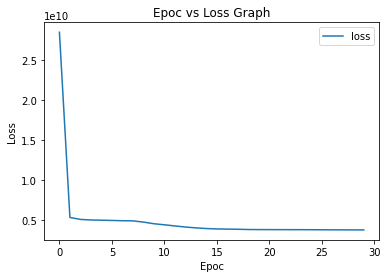

In [78]:
loss_df.plot()
plt.title('Epoc vs Loss Graph')
plt.xlabel('Epoc')
plt.ylabel('Loss')
plt.show()

The observed graph of the training loss as training progresses provides valuable insights into the performance and convergence of the model. The significant dip in loss after the second epoch indicates that the model quickly started to learn and improve its predictions. This initial improvement is often observed as the model adjusts its parameters to better fit the training data.

Furthermore, after the second epoch, the loss continues to decrease gradually and reaches a plateau state from the 15th epoch onwards. This plateau suggests that the model has converged to a stable solution, where further training epochs do not result in significant improvements in reducing the loss. This indicates that the model has learned as much as it can from the available training data.

The consistent decrease and plateauing of the loss indicate that there is no sign of overfitting or underfitting of the model. Overfitting occurs when the model becomes too complex and starts to memorize the training data, resulting in poor generalization to new data. Underfitting, on the other hand, occurs when the model is too simple to capture the underlying patterns in the data. The low loss values achieved suggest that the model has found an appropriate level of complexity and is performing well in capturing the patterns in the training data.

Overall, the observed graph indicates that the model is performing effectively and has reached a stable state with low training loss. This suggests that the model is well-suited for the given task and demonstrates its ability to make accurate predictions without overfitting or underfitting.

In [79]:
mse_train = nn.evaluate(Z_train, y_train)
mse_test = nn.evaluate(Z_test, y_test)

7024/7024 [==============================] - 11s 1ms/step - loss: 3712392960.0000


In [80]:
mean_y_train = np.mean(y_train)
tss = np.sum((y_train - mean_y_train) ** 2)

In [81]:
r2_train = 1 - (mse_train / tss)
r2_train

0.9999997938715115

In [82]:
r2_test = 1 - (mse_test / tss)
r2_test

0.9999997940978947

In [83]:
np.sqrt(nn.evaluate(Z_test, y_test))

7024/7024 [==============================] - 11s 1ms/step - loss: 3712392960.0000


60929.40964755854

In [84]:
nn_pred = nn.predict(Z_test)

7024/7024 [==============================] - 11s 973us/step


In [85]:
nn_pred = pd.DataFrame(nn_pred)

In [86]:
nn_pred.head()

,0
0,136115.40625
1,294578.34375
2,268235.18750
3,327190.90625
4,510391.25000


In [87]:
nn_y_test = y_test.reset_index(drop=True)

In [88]:
nn_pred_df = pd.DataFrame(nn_y_test)

In [89]:
nn_df = pd.concat([nn_pred_df, pd.DataFrame({'model_predictions': nn_pred[0]})], axis = 1)

In [90]:
nn_df.head()

,resale_price,model_predictions
0,139000.0,136115.40625
1,303000.0,294578.34375
2,186000.0,268235.18750
3,330000.0,327190.90625
4,500000.0,510391.25000


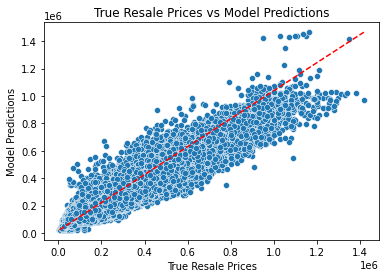

In [91]:
sns.scatterplot(x=nn_df['resale_price'], y=nn_df['model_predictions'])
plt.plot([min(nn_df['resale_price']), max(nn_df['resale_price'])], [min(nn_df['model_predictions']), max(nn_df['model_predictions'])], color='red', linestyle='--')
plt.title('True Resale Prices vs Model Predictions')
plt.xlabel('True Resale Prices')
plt.ylabel('Model Predictions')
plt.show()

The observed scatter of data points were slightly distributed below the diagonal line suggests that the model tends to underestimate the true values. This indicates a lack of systematic bias in the model's predictions. 

It is also observed that the fact that the data points are still widely scattered around the diagonal line indicates a high degree of prediction error. The scattered distribution suggests that the model struggles to accurately predict the true values and exhibits a significant level of variability in its predictions. This high prediction error implies that the model may not be effectively capturing the underlying patterns and relationships within the data.

#### Observations

Upon exploring the neural network model, it was discovered that both the train and test scores achieved an impressive 99.9%. At first glance, this suggests that the model is capable of capturing and understanding the underlying patterns and trends within the training and test data, thus achieving a high level of performance. However, despite the high scores, the root mean squared error (RMSE) score stands at 61,779, indicating the presence of overfitting.

The high R-squared scores indicate that the model can explain a large portion of the variance in the target variable, which is a positive aspect. However, the high RMSE score implies that, on average, the model's predictions exhibit significant errors compared to the true values. This discrepancy indicates a lack of accuracy and a substantial amount of residual error between the predicted values and the actual observations.

In light of these findings, it becomes evident that the model's performance needs improvement, especially when considering its ability to generalize to unseen data. Therefore, exploring techniques like boosting could be a promising approach to enhance the model's performance and mitigate the overfitting issue. By applying boosting algorithms, such as AdaBoost or Gradient Boosting, the model's ability to generalize and make accurate predictions on new, unseen data can be improved, potentially reducing both the RMSE score and the overfitting problem.

### XG Boost

In [92]:
xgb = XGBRegressor()

In [93]:
pipe_xgb_gs = Pipeline([('sc',sc),('xgb',xgb)])

In [94]:
pipe_xgb_gs_params = {'xgb__max_depth':[7,8],
                      'xgb__eta':[0.2,0.3],
                      'xgb__random_state':[42]}

In [95]:
xgb_gs = GridSearchCV(pipe_xgb_gs, pipe_xgb_gs_params, cv=5, verbose=1, error_score='raise')

In [96]:
xgb_model = xgb_gs.fit(X_train, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge

In [97]:
xgb_gs.best_params_

{'xgb__eta': 0.3, 'xgb__max_depth': 8, 'xgb__random_state': 42}

In [98]:
xgb_gs.score(X_test,y_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9824838814631156

In [99]:
xgb_gs.score(X_train,y_train)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9841346714191771

In [100]:
xgb_pred = xgb_model.predict(X_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [101]:
np.sqrt(metrics.mean_squared_error(y_test, xgb_pred))

21620.20144680044

In [102]:
xgb_y_test = y_test.reset_index(drop=True)

In [103]:
xgb_pred_df = pd.DataFrame(xgb_y_test)

In [104]:
xgb_pred_df.head()

,resale_price
0,139000.0
1,303000.0
2,186000.0
3,330000.0
4,500000.0


In [105]:
xgb_df = pd.concat([xgb_pred_df, pd.DataFrame({'model_predictions': xgb_pred})], axis = 1)

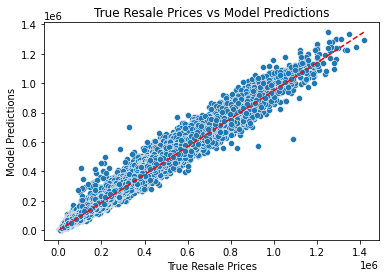

In [106]:
sns.scatterplot(x=xgb_df['resale_price'], y=xgb_df['model_predictions'])
plt.plot([min(xgb_df['resale_price']), max(xgb_df['resale_price'])], [min(xgb_df['model_predictions']), max(xgb_df['model_predictions'])], color='red', linestyle='--')
plt.title('True Resale Prices vs Model Predictions')
plt.xlabel('True Resale Prices')
plt.ylabel('Model Predictions')
plt.show()

The analysis of the data points in relation to the diagonal line reveals interesting insights about the model's performance. The initial observation of a relatively even spread of data points above and below the diagonal line indicates that the model's predictions have some degree of deviation from the true values. However, a closer inspection reveals that some of the data points are slightly above the diagonal line, suggesting a tendency of the model to slightly overestimate the true values.

The presence of data points above the diagonal line implies that the model consistently predicts values that are higher than the actual values. Although this overestimation is slight, it indicates a systematic bias in the model's predictions. The reasons for this bias could be multifaceted and require future investigations. 

On a positive note, the close clustering of data points around the diagonal line indicates that, on average, the model's predictions are relatively accurate. When the data points are tightly grouped around the diagonal line, it suggests that the predicted values closely align with the true values. This clustering and proximity of data points to the diagonal line are indicative of a good level of agreement between the model's predictions and the actual observed values.

#### Observations

Upon conducting hyperparameter tuning on XGBoost, it is evident that the train and test R-squared scores remain consistently high, at 98.2% and 98.4% respectively. Although these scores are lower compared to the neural network model's R-squared score of 99.9%, a notable advantage of XGBoost lies in its significantly lower root mean squared error (RMSE) scores. With an RMSE score of 21,620, XGBoost outperforms the neural network model's RMSE score of 60,929.

The lower RMSE score indicates that the XGBoost model is more accurate in predicting resale house pricing, with an average prediction error range of approximately ±21,620. This discrepancy in RMSE scores indicates that XGBoost is not suffering from overfitting or underfitting, making it a strong candidate for selecting a model to predict house prices. Despite the slightly lower R-squared scores compared to the neural network, the combination of high R-squared scores and low RMSE scores reinforces the effectiveness and reliability of the XGBoost model for accurate price predictions in the resale housing market.

## Main Discussion

| Model                     | Train R-squared (%) | Test R-squared (%) | RMSE   |
|:-------------------------:|:-------------------:|:------------------:|:------:|
| Linear Regression         | 83.6                | 83.6               | 66,048 |
| RidgeCV (Tuned)           | 83.6                | 83.6               | 66,048 |
| LassoCV (Tuned)           | 83.6                | 83.6               | 66,060 |
| ElasticNetCV (Tuned)      | 81.5                | 81.6               | 70,276 |
| Neural Network            | 99.9                | 99.9               | 60,929 |
| XGBoost (Tuned)           | 98.2                | 98.4               | 21,620 |



Based on the provided table, it is evident that XGBoost outperforms other models with hyperparameter tuning in terms of both the R-squared score and RMSE. XGBoost demonstrates the highest R-squared score and the lowest RMSE score among the models considered. 

Comparing XGBoost to the base model, which is linear regression, the improvement in performance is striking. XGBoost exhibits an ~18% increase in the R-squared score, indicating a better ability to explain the variance in the resale house prices compared to linear regression. Additionally, the RMSE score decreases by 35.4% when using XGBoost, indicating a substantial reduction in the average prediction error range. 

Considering the significant improvement in both the R-squared score and RMSE, it is reasonable to select XGBoost as the chosen model for predicting resale house prices. XGBoost demonstrates superior predictive power and provides more accurate and precise predictions compared to the base model and other models with hyperparameter tuning.

## Future Works

For future work aimed at improving model predictions, several avenues can be explored. Firstly, with increased computational power, incorporating additional features could enhance the predictive performance. For instance, considering factors like the types of nearby malls or schools in relation to the resale house, as well as factors such as the number of sunshine hours and the direction the sunlight faces the house, could provide valuable insights. Furthermore, introducing additional feature engineering techniques, such as incorporating the distance to various amenities, might contribute to more accurate predictions.

Moreover, considering the temporal nature of the data, incorporating time series models could be a promising direction for improvement. Comparing the performance of XGBoost with other time series models, such as ARIMA or LSTM, would allow for a thorough evaluation of XGBoost's effectiveness in capturing and predicting temporal patterns in resale house prices.

Overall, by expanding the set of features and considering alternative modeling techniques, future research endeavors can strive to further enhance the predictive capabilities of the model, potentially leading to more accurate and robust predictions for resale house pricing.

## Conclusion

In conclusion, the analysis of resale house price prediction has revealed the superiority of the XGBoost model in terms of its predictive performance. With its high R-squared scores and low RMSE score, the XGBoost model demonstrates its ability to capture the underlying patterns and accurately predict resale house prices. By utilizing this model, stakeholders in the housing market can make more informed decisions, whether they are buyers looking for affordable options or sellers determining the optimal pricing strategy.

However, it is important to acknowledge that the prediction of housing prices is a complex task influenced by numerous factors beyond the scope of this analysis. Future research could explore additional features and data sources to further enhance the accuracy and robustness of the models. Furthermore, incorporating external factors such as economic indicators, policy changes, and market trends could provide a more comprehensive understanding of housing price dynamics.

Overall, the utilization of advanced machine learning models, such as XGBoost, in resale house price prediction offers significant potential for improving decision-making processes and fostering a more transparent and efficient housing market. By leveraging the power of data and sophisticated modeling techniques, stakeholders can navigate the challenges of the housing market with greater confidence and optimize their outcomes.